<a href="https://www.kaggle.com/code/minhjuniordinh/2019-nsw-bushfire-and-fraud-analysis?scriptVersionId=294338116" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# - 2019 NSW Bushfire and Fraud Analysis -
This notebook analyses any trends and relations between bushfire severity and fraud rates. Luminance readings from NASA sattelites were used to measure bushfire severity. Fraud rates for NSW were web scrapped with permission from the BOSCAR crime website. 

In [1]:
# Remove conflicting packages (forces clean reinstall)
remove.packages("gtable")
remove.packages("ggplot2")

# Load required libraries
library(tidyr)

# Web scraping:
library(httr)        # HTTP requests
library(jsonlite)    # JSON parsing

# Data cleaning:
library(readr)       # Fast, friendly data import
library(dplyr)       # Data manipulation verbs
library(lubridate)   # Date handling

library(stringdist)  # Approximate string matching (e.g., fuzzy suburb matching)
library(stringr)     # Consistent string manipulation helpers
library(forcats)     # Factor manipulation (reordering, recoding)

# Install plotting packages (if missing)
install.packages("ggplot2", dependencies = TRUE)

# Data visualisation:
library(sf)          # Spatial data + shapefiles
library(ggplot2)     # Grammar of graphics
library(scales)      # Axis/label formatting, transformations

# Additional packages:
install.packages("tidyverse", dependencies = TRUE)  # Meta-package of core tidy tools
install.packages("patchwork")                       # Combine ggplot2 plots easily

Removing package from ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Removing package from ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Attaching package: ‘lubridate’




The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union





Attaching package: ‘stringdist’




The following object is masked from ‘package:tidyr’:

    extract




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



also installing the dependencies ‘gtable’, ‘S7’, ‘scales’, ‘vdiffr’




Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE




Attaching package: ‘scales’




The following object is masked from ‘package:readr’:

    col_factor




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



also installing the dependency ‘mockr’




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Web Scraping Crime Rate Data 

Since the line graph data needed is not available for download from BOSCAR crimetool (https://crimetool.bocsar.nsw.gov.au/bocsar/), it needs to be web scrapped from the interactive graph. I inspected element and looked at the network tab, examining the json file and required parameters. 

This web scraping code was made in March of 2025, so it will not work anymore as the BOSCAR webste has changed.

**Ensure you receive permission before web scrapping.**

In [2]:
# # Define API URL - has a buncha parameters in the url offence=-1400 defines fraud theft tab, all region ids for NSW
# # this url was taken from inspect element -> network tab, capturing the data 
# url <- "https://crimetool.bocsar.nsw.gov.au/bocsar/api/Stats?region_id=10050&region_id=10180&region_id=10250&region_id=10300&region_id=10470&region_id=10500&region_id=10550&region_id=10600&region_id=10650&region_id=10750&region_id=10800&region_id=10850&region_id=10900&region_id=10950&region_id=11150&region_id=11200&region_id=11250&region_id=11300&region_id=11350&region_id=11400&region_id=11450&region_id=11500&region_id=11520&region_id=11570&region_id=11600&region_id=11650&region_id=11700&region_id=11720&region_id=11730&region_id=11750&region_id=11800&region_id=12000&region_id=12150&region_id=12160&region_id=12350&region_id=12380&region_id=12390&region_id=12700&region_id=12730&region_id=12750&region_id=12850&region_id=12870&region_id=12900&region_id=12930&region_id=12950&region_id=13010&region_id=13310&region_id=13340&region_id=13450&region_id=13550&region_id=13660&region_id=13800&region_id=13850&region_id=13910&region_id=14000&region_id=14100&region_id=14170&region_id=14220&region_id=14300&region_id=14350&region_id=14400&region_id=14500&region_id=14550&region_id=14600&region_id=14650&region_id=14700&region_id=14750&region_id=14850&region_id=14870&region_id=14900&region_id=14920&region_id=14950&region_id=15050&region_id=15240&region_id=15270&region_id=15300&region_id=15350&region_id=15520&region_id=15560&region_id=15650&region_id=15700&region_id=15750&region_id=15800&region_id=15850&region_id=15900&region_id=15950&region_id=15990&region_id=16100&region_id=16150&region_id=16200&region_id=16260&region_id=16350&region_id=16380&region_id=16400&region_id=16490&region_id=16550&region_id=16610&region_id=16700&region_id=16900&region_id=16950&region_id=17000&region_id=17040&region_id=17080&region_id=17100&region_id=17150&region_id=17200&region_id=17310&region_id=17350&region_id=17400&region_id=17420&region_id=17550&region_id=17620&region_id=17640&region_id=17650&region_id=17750&region_id=17850&region_id=17900&region_id=17950&region_id=18020&region_id=18050&region_id=18100&region_id=18200&region_id=18250&region_id=18350&region_id=18400&region_id=18450&region_id=18500&region_id=18710&region_id=18809&region_id=18859&advanced_option=premise&base_title=Incidents%20of%20Assault%20&last_region=11500&stats_type=trend_chart&region_type=1&offence=-1400&source=I&start_date=2019-1&end_date=2021-12"

# # Make the GET request
# response <- GET(url)

# # Check if request was successful
# if (status_code(response) == 200) {
#   # Parse JSON content
#   json_data <- fromJSON(content(response, "text", encoding = "UTF-8"))
  
#   # Print JSON structure to find relevant fields
#   print(str(json_data, max.level = 2))
  
#   # If data is nested, extract relevant part
#   if ("data" %in% names(json_data)) {
#     extracted_data <- json_data$data  # Adjust if needed
    
#     # Convert to dataframe
#     crime_data <- as.data.frame(extracted_data)
    
#     # Ensure data is not empty before writing to CSV
#     if (nrow(crime_data) > 0) {
#       file_path <- file.path(getwd(), "crime_data.csv")  # Define file path
#       write.csv(crime_data, file = file_path, row.names = FALSE)  # Save to CSV
      
#       print(paste("Data successfully saved to", file_path))
#     } else {
#       print("No data extracted. Check the API response structure.")
#     }
#   } else {
#     print("Unexpected JSON structure. Check the output of str(json_data).")
#   }
# } else {
#   print(paste("Failed to retrieve data. Status code:", status_code(response)))
# }

In [3]:
# # Writing the dataframe to a CSV file
# write.csv(crime_data, file = "crime_data.csv", row.names = FALSE)  # Exclude row names

The above csv file from web scraping has been imported as a Kaggle dataset called 'crime-data' on the right side

---

# Data Cleaning

## Cleaning Crime Rate Data

In [4]:
## Cleaning the Boscar NSW webscraped data:
crime_data <- read_csv("/kaggle/input/crime-data/crime_data.csv")

head(crime_data)

# set crime_data to a new dataframe when cleaning 
crime_data_v1 <- crime_data 

Rows: 37 Columns: 132


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (132): V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15,...



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Date,New South Wales (Stable),CANADA BAY (Stable),LISMORE (Up 12.3% per year),BAYSIDE (Stable),SHELLHARBOUR (Stable),LACHLAN (Stable),BALLINA (Stable),THE HILLS SHIRE (Stable),KEMPSEY (Stable),⋯,CAMPBELLTOWN (Stable),GUNNEDAH (Stable),BROKEN HILL (Stable),URALLA (Stable),MOSMAN (Stable),TENTERFIELD (Stable),PORT MACQUARIE-HASTINGS (Up 9.9% per year),GOULBURN MULWAREE (Stable),BLACKTOWN (Stable),SUTHERLAND SHIRE (Down 7.6% per year)
January 2020,75.1,27.3,115.3,60.3,58.8,96.6,46.1,39.2,111.3,⋯,110.6,130.8,288.3,82.7,13.6,147.8,56.3,97.3,113,57
December 2021,76,32.3,157.8,52.2,54.9,178.8,45.5,34.3,139.5,⋯,80.4,152.8,215.2,83.4,17.6,117.6,91.2,52.9,88,42.9
July 2020,59.4,20.7,47.5,59.7,36.1,96.6,35.1,25.2,98.2,⋯,81.5,84.6,141.3,16.5,6.8,133,55.1,56.5,76.5,37.8
October 2020,70.3,17.5,79.1,50.6,37.4,128.8,90,28.5,157.2,⋯,87.8,146.1,209.2,132.3,23.7,88.7,65.6,53.3,90,50.5
December 2019,77.9,29.2,107.6,65,58.7,129.9,56,37.7,134.5,⋯,97.1,118.3,206,66.5,35.5,45.5,79.3,70.7,102,53.8


The data extracts fraud rates per 100,000 people for each suburb monthly between Jan 2019 to Dec 2021. 

### Cleaning column names

In [5]:
# Extract first row as names
new_names <- crime_data_v1[1, ] |> unlist(use.names = FALSE)

# Clean the names BEFORE assigning
new_names <- gsub("\\(.*\\)", "", new_names)   # remove parentheses
new_names <- trimws(new_names)                 # trim whitespace
new_names <- tools::toTitleCase(tolower(new_names))  # title case

# Replace empty or NA names with safe placeholders
new_names[new_names == "" | is.na(new_names)] <- paste0("Column_", seq_len(sum(new_names == "" | is.na(new_names))))

# Apply names and drop first row
crime_data_v1 <- crime_data_v1[-1, ]
colnames(crime_data_v1) <- new_names

head(crime_data_v1)

Date,New South Wales,Canada Bay,Lismore,Bayside,Shellharbour,Lachlan,Ballina,The Hills Shire,Kempsey,⋯,Campbelltown,Gunnedah,Broken Hill,Uralla,Mosman,Tenterfield,Port Macquarie-Hastings,Goulburn Mulwaree,Blacktown,Sutherland Shire
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
January 2020,75.1,27.3,115.3,60.3,58.8,96.6,46.1,39.2,111.3,⋯,110.6,130.8,288.3,82.7,13.6,147.8,56.3,97.3,113,57
December 2021,76,32.3,157.8,52.2,54.9,178.8,45.5,34.3,139.5,⋯,80.4,152.8,215.2,83.4,17.6,117.6,91.2,52.9,88,42.9
July 2020,59.4,20.7,47.5,59.7,36.1,96.6,35.1,25.2,98.2,⋯,81.5,84.6,141.3,16.5,6.8,133,55.1,56.5,76.5,37.8
October 2020,70.3,17.5,79.1,50.6,37.4,128.8,90,28.5,157.2,⋯,87.8,146.1,209.2,132.3,23.7,88.7,65.6,53.3,90,50.5
December 2019,77.9,29.2,107.6,65,58.7,129.9,56,37.7,134.5,⋯,97.1,118.3,206,66.5,35.5,45.5,79.3,70.7,102,53.8
April 2021,67.3,33.5,117.2,55.6,43.1,81.3,26,27.5,81.1,⋯,90,137.5,169.9,16.7,21.1,117.6,62.3,74.7,87.5,41.6


### Cleaning the Date Column
The `Date` column is in str format and needs to be converted to date format and standardised to DD/MM/YYYY format. It also needs to be sorted correctly. 

In [6]:
crime_data_v1 <- crime_data_v1 %>%
  mutate(
    Date = as.Date(paste("1", Date), format = "%d %B %Y"),  # First day of month
    Date = as.Date(cut(Date + 31, "month")) - 1,            # Last day of month
    Date = format(Date, "%d/%m/%Y")                         # Overwrite Date with formatted string
  ) %>%
  arrange(as.Date(Date, "%d/%m/%Y"))  # Sort by Date

head(crime_data_v1)

Date,New South Wales,Canada Bay,Lismore,Bayside,Shellharbour,Lachlan,Ballina,The Hills Shire,Kempsey,⋯,Campbelltown,Gunnedah,Broken Hill,Uralla,Mosman,Tenterfield,Port Macquarie-Hastings,Goulburn Mulwaree,Blacktown,Sutherland Shire
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
31/01/2019,75.4,13.5,103,57.8,62.8,162.3,42.6,24.2,137.9,⋯,77.2,134.1,211.7,49.9,12.9,136.5,58,90,93,57.7
28/02/2019,65.7,29.2,98.4,53.3,38.2,97.4,49.3,21.4,107.6,⋯,79.6,55.2,171.7,16.6,9.7,182,63.9,41.8,93.8,49.9
31/03/2019,72.6,22.9,89.3,53.3,50.5,97.4,56,28.1,124.4,⋯,87.8,110.4,131.6,49.9,22.6,257.8,61.5,51.4,101,49.9
30/04/2019,65,15.6,54.9,61.7,47.8,97.4,65,28.7,94.1,⋯,77.8,71,183.1,33.3,25.8,166.8,52.1,54.6,83.6,56.8
31/05/2019,63.4,19.8,93.8,53.8,54.6,97.4,33.6,27.5,87.4,⋯,85.4,78.9,137.3,33.3,22.6,45.5,60.3,54.6,87.9,44.2
30/06/2019,61.5,14.6,121.3,63.9,47.8,276,17.9,29.2,124.4,⋯,76.1,63.1,188.8,83.2,32.3,121.3,31.9,96.4,74,45.5


### Identifying nulls
The suburb Warren and Balranald are all just null value but will not be removed for the shapefile

In [7]:
# Identify columns with nulls
null_columns <- colnames(crime_data_v1)[colSums(is.na(crime_data_v1)) > 0]

# Create a dataframe with only the columns containing null values
crime_data_null_columns <- crime_data_v1[, null_columns]

# Display the first few rows of the dataframe
head(crime_data_null_columns)

Hay,Warren,Balranald,Carrathool,Unincorporated Far West,Bourke,Lord Howe Island,Central Darling,Brewarrina,Bogan
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


There are 10 suburbs that have all nulls. However, these will not be removed from analysis as they are still important for the shapefile to match to a suburb. 

### Inspect clean data

In [8]:
head(crime_data_v1)

Date,New South Wales,Canada Bay,Lismore,Bayside,Shellharbour,Lachlan,Ballina,The Hills Shire,Kempsey,⋯,Campbelltown,Gunnedah,Broken Hill,Uralla,Mosman,Tenterfield,Port Macquarie-Hastings,Goulburn Mulwaree,Blacktown,Sutherland Shire
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
31/01/2019,75.4,13.5,103,57.8,62.8,162.3,42.6,24.2,137.9,⋯,77.2,134.1,211.7,49.9,12.9,136.5,58,90,93,57.7
28/02/2019,65.7,29.2,98.4,53.3,38.2,97.4,49.3,21.4,107.6,⋯,79.6,55.2,171.7,16.6,9.7,182,63.9,41.8,93.8,49.9
31/03/2019,72.6,22.9,89.3,53.3,50.5,97.4,56,28.1,124.4,⋯,87.8,110.4,131.6,49.9,22.6,257.8,61.5,51.4,101,49.9
30/04/2019,65,15.6,54.9,61.7,47.8,97.4,65,28.7,94.1,⋯,77.8,71,183.1,33.3,25.8,166.8,52.1,54.6,83.6,56.8
31/05/2019,63.4,19.8,93.8,53.8,54.6,97.4,33.6,27.5,87.4,⋯,85.4,78.9,137.3,33.3,22.6,45.5,60.3,54.6,87.9,44.2
30/06/2019,61.5,14.6,121.3,63.9,47.8,276,17.9,29.2,124.4,⋯,76.1,63.1,188.8,83.2,32.3,121.3,31.9,96.4,74,45.5


### Write clean data to csv 
Not needed in kaggle so I just commented it out

In [9]:
# write.csv(crime_data_v1, "crime_data_clean.csv", row.names = FALSE)

## Cleaning NSW shapefile suburb boundaries
Shapefile taken from government website: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/LGA_2024_AUST_GDA2020.zip 

In [10]:
# Load NSW suburb boundaries
suburbs_aus <- st_read("/kaggle/input/nsw-shapefile/LGA_2024_AUST_GDA2020/LGA_2024_AUST_GDA2020.shp")

suburbs_nsw <- suburbs_aus %>%
  filter(suburbs_aus$STE_CODE21 == 1) # filter for NSW areas only

Reading layer `LGA_2024_AUST_GDA2020' from data source 
  `/kaggle/input/nsw-shapefile/LGA_2024_AUST_GDA2020/LGA_2024_AUST_GDA2020.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 566 features and 8 fields (with 19 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 96.81695 ymin: -43.7405 xmax: 167.998 ymax: -9.142163
Geodetic CRS:  GDA2020


Now to check if suburbs_nsw suburb names match with the ones in crime_data_v1 (cleaned)

In [11]:
# Get unique suburb names from suburbs_nsw
suburb_list <- unique(suburbs_nsw$LGA_NAME24)

# Get all column names from crime_data_v1
crime_suburbs <- colnames(crime_data_v1)

# Check for mismatches
# non_matching_suburbs <- suburb_list[!(suburb_list %in% crime_suburbs)]
non_matching_suburbs <- crime_suburbs[!(crime_suburbs %in% suburb_list)]

# Show the non-matching suburbs
print('These are the suburbs that do not match exactlty')
non_matching_suburbs

[1] "These are the suburbs that do not match exactlty"


[1] "Date"                         "New South Wales"             
 [3] "Bayside"                      "The Hills Shire"             
 [5] "Greater Hume Shire"           "Warrumbungle Shire"          
 [7] "Dubbo Regional"               "Queanbeyan-Palerang Regional"
 [9] "Unincorporated Far West"      "Central Coast"               
[11] "Snowy Monaro Regional"        "Tamworth Regional"           
[13] "Ku-Ring-Gai"                  "Mid-Western Regional"        
[15] "Lord Howe Island"             "Armidale Regional"           
[17] "Upper Hunter Shire"           "Bathurst Regional"           
[19] "Upper Lachlan Shire"          "Campbelltown"                
[21] "Sutherland Shire"

Now correct the nsw suburb mismatches. This prints what the original suburb name was replaced with for error checking.

In [12]:
# Get unique suburb names from suburbs_nsw
suburb_list <- unique(suburbs_nsw$LGA_NAME24)

# Get crime_data_v1 column names (except Date)
crime_suburbs <- setdiff(colnames(crime_data_v1), "Date")

# # Identify mismatches: names in suburbs_nsw not found in crime_data_v1
mismatches <- suburb_list[!suburb_list %in% crime_suburbs]
# mismatches <- crime_suburbs[!(crime_suburbs %in% suburb_list)]

# Only perform matching on mismatches
get_best_match <- function(name, reference_list) {
  distances <- stringdist::stringdist(tolower(name), tolower(reference_list), method = "jw")
  best_match <- reference_list[which.min(distances)]
  return(best_match)
}

# Create a lookup table for mismatches only
mismatch_mapping <- data.frame(
  original = mismatches,
  matched = sapply(mismatches, get_best_match, reference_list = crime_suburbs),
  stringsAsFactors = FALSE
)

# Display the mapping of replaced suburb names
cat("Suburb name replacements:\n")
print(mismatch_mapping)

Suburb name replacements:


                                                                   original
Armidale                                                           Armidale
Bathurst                                                           Bathurst
Bayside (NSW)                                                 Bayside (NSW)
Campbelltown (NSW)                                       Campbelltown (NSW)
Central Coast (NSW)                                     Central Coast (NSW)
Dubbo                                                                 Dubbo
Greater Hume                                                   Greater Hume
Ku-ring-gai                                                     Ku-ring-gai
Mid-Western                                                     Mid-Western
Queanbeyan-Palerang                                     Queanbeyan-Palerang
Snowy Monaro                                                   Snowy Monaro
Sutherland                                                       Sutherland
Tamworth    

If this matching algorithm were applied now, it would mismatch a lot of suburbs. 
- Original gets changed to matched to ensure consistency with the fraud data 

After extensive manual checking, suburbs that did not exist in crime_data_v1 and matched incorrectly were: 
- No usual address (NSW), Migratory - Offshore - Shipping (NSW)

These suburbs could not match as they were removed from crime_data_v1 for being nonsensical suburbs like offshore shipping

In [13]:
# List of incorrectly matched suburb names to be flagged
bad_suburbs <- c(
  "No usual address (NSW)",
  "Migratory - Offshore - Shipping (NSW)"
)

# Add a flag to identify bad suburbs instead of removing them so the map data is still complete, will just have nulls for fraud rates
suburbs_nsw$bad_flag <- ifelse(suburbs_nsw$LGA_NAME24 %in% bad_suburbs, TRUE, FALSE)

# Create suburbs_nsw_v1 with all entries, preserving flagged bad suburbs
suburbs_nsw_v1 <- suburbs_nsw

In [14]:
# Get updated unique suburb names from non-flagged entries
suburb_list <- unique(suburbs_nsw_v1$LGA_NAME24[suburbs_nsw_v1$bad_flag == FALSE])

# Get crime_data_v1 column names (excluding 'Date')
crime_suburbs <- colnames(crime_data_v1)
crime_suburbs <- crime_suburbs[crime_suburbs != "Date"]

# Identify mismatches
mismatches <- suburb_list[!suburb_list %in% crime_suburbs]

# Apply matching function to only the mismatched suburb names
mismatch_mapping <- data.frame(
  original = mismatches,
  matched = sapply(mismatches, get_best_match, reference_list = crime_suburbs),
  stringsAsFactors = FALSE
)

# Print the mapping for manual review
cat("Updated suburb name replacements after removing incorrect matches:\n")
print(mismatch_mapping)

Updated suburb name replacements after removing incorrect matches:


                               original                      matched
Armidale                       Armidale            Armidale Regional
Bathurst                       Bathurst            Bathurst Regional
Bayside (NSW)             Bayside (NSW)                      Bayside
Campbelltown (NSW)   Campbelltown (NSW)                 Campbelltown
Central Coast (NSW) Central Coast (NSW)                Central Coast
Dubbo                             Dubbo               Dubbo Regional
Greater Hume               Greater Hume           Greater Hume Shire
Ku-ring-gai                 Ku-ring-gai                  Ku-Ring-Gai
Mid-Western                 Mid-Western         Mid-Western Regional
Queanbeyan-Palerang Queanbeyan-Palerang Queanbeyan-Palerang Regional
Snowy Monaro               Snowy Monaro        Snowy Monaro Regional
Sutherland                   Sutherland             Sutherland Shire
Tamworth                       Tamworth            Tamworth Regional
The Hills                     The 

Great, now the mismatches are corrected well, we can apply this to suburbs_nsw_v1 so that it only matches the correct suburbs from crima_data_v1. 

In [15]:
# Replace mismatched values in suburbs_nsw_v1 using mismatch_mapping
suburbs_nsw_v1$LGA_NAME24 <- sapply(suburbs_nsw_v1$LGA_NAME24, function(x) {
  if (x %in% mismatch_mapping$original) {
    mismatch_mapping$matched[match(x, mismatch_mapping$original)]
  } else {
    x
  }
})

Now we can move on to looking at the satellite luminance data to assess bushfire severity 

## Cleaning NASA luminance data
Data shows luminance from space of Australia during the period Jan 2019 - Dec 2021, this includes the NSW Black Summer Bushfire period.
- We will not load the csv data and filter out only for the NSW area. 
- All values regardless of confidence scores kept to not miss any areas where it is difficult to detect fire in NSW
  - https://forum.earthdata.nasa.gov/viewtopic.php?t=5182
  - The high sample size and data combined from all 3 satellites will mitigate error. 

In [16]:
# Read and process each CSV file
fire_SV_C2 <- read_csv("/kaggle/input/nasa-luminance-2019-to-2021/nasa_data2019to2021/csv/DL_FIRE_J1V-C2_614667/fire_archive_J1V-C2_614667.csv") %>%
  mutate(acq_date = format(ymd(acq_date), "%d/%m/%Y")) %>%
  select(-confidence) %>%
  filter(between(latitude, -38, -28),  # Filter for the NSW area (with buffer) so data is managable
         between(longitude, 141, 153)) # (lat ~ -38 to -28, lon ~ 141 to 153 for NSW)

fire_M_C61 <- read_csv("/kaggle/input/nasa-luminance-2019-to-2021/nasa_data2019to2021/csv/DL_FIRE_M-C61_614665/fire_archive_M-C61_614665.csv") %>%
  mutate(acq_date = format(ymd(acq_date), "%d/%m/%Y")) %>%
  select(-confidence) %>%
  filter(between(latitude, -38, -28),
         between(longitude, 141, 153))

fire_J1V_C2 <- read_csv("/kaggle/input/nasa-luminance-2019-to-2021/nasa_data2019to2021/csv/DL_FIRE_SV-C2_614669/fire_archive_SV-C2_614669.csv") %>%
  mutate(acq_date = format(ymd(acq_date), "%d/%m/%Y")) %>%
  select(-confidence) %>%
  filter(between(latitude, -38, -28),
         between(longitude, 141, 153))

Rows: 3196611 Columns: 15


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): acq_time, satellite, instrument, confidence, daynight
dbl  (9): latitude, longitude, brightness, scan, track, version, bright_t31,...
date (1): acq_date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 640061 Columns: 15


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): acq_time, satellite, instrument, daynight
dbl  (10): latitude, longitude, brightness, scan, track, confidence, version...
date  (1): acq_date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 3247392 Columns: 15


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): acq_time, satellite, instrument, confidence, daynight
dbl  (9): latitude, longitude, brightness, scan, track, version, bright_t31,...
date (1): acq_date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
head(fire_SV_C2)
head(fire_M_C61)
head(fire_J1V_C2)

latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,version,bright_t31,frp,daynight,type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
-34.45865,150.8791,336.56,0.54,0.51,01/01/2019,0311,N20,VIIRS,2,304.52,5.42,D,2
-31.70497,152.7205,335.66,0.40,0.44,01/01/2019,0311,N20,VIIRS,2,295.75,2.55,D,0
-31.80123,151.9360,340.15,0.44,0.46,01/01/2019,0311,N20,VIIRS,2,300.89,3.49,D,0
-32.61467,152.1675,352.96,0.44,0.46,01/01/2019,0311,N20,VIIRS,2,301.65,25.09,D,0
-32.87776,149.7033,342.11,0.61,0.53,01/01/2019,0311,N20,VIIRS,2,301.11,5.97,D,0
-33.75599,150.9097,331.44,0.53,0.50,01/01/2019,0311,N20,VIIRS,2,306.13,4.18,D,0


latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,version,bright_t31,frp,daynight,type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
-37.8204,145.3003,325.5,1.3,1.1,01/01/2019,0404,Aqua,MODIS,6.03,310.0,12.1,D,2
-37.9064,145.2468,324.5,1.3,1.1,01/01/2019,0404,Aqua,MODIS,6.03,306.6,9.0,D,2
-37.8185,144.7629,324.5,1.3,1.1,01/01/2019,0404,Aqua,MODIS,6.03,305.6,7.4,D,0
-32.6193,152.1570,323.7,1.4,1.2,01/01/2019,0405,Aqua,MODIS,6.03,300.7,17.4,D,0
-32.6166,152.1718,325.9,1.4,1.2,01/01/2019,0405,Aqua,MODIS,6.03,302.1,22.7,D,0
-32.6126,152.1651,315.3,1.0,1.0,01/01/2019,1506,Aqua,MODIS,6.03,293.1,13.1,N,0


latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,version,bright_t31,frp,daynight,type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
-35.04277,150.4099,332.88,0.45,0.39,01/01/2019,0401,N,VIIRS,2,300.03,3.99,D,0
-35.04369,150.4050,340.78,0.45,0.39,01/01/2019,0401,N,VIIRS,2,298.77,3.99,D,0
-35.04565,150.4086,347.28,0.45,0.39,01/01/2019,0401,N,VIIRS,2,301.96,8.78,D,0
-34.46127,150.8841,343.76,0.47,0.40,01/01/2019,0401,N,VIIRS,2,310.21,11.02,D,2
-34.45858,150.8780,333.76,0.47,0.40,01/01/2019,0401,N,VIIRS,2,308.20,4.46,D,2
-34.45493,150.8770,344.53,0.47,0.40,01/01/2019,0401,N,VIIRS,2,310.98,6.26,D,2


Since the fire_archive data captured by the 3 satellites uses the same columns, we can simply combine the 3 csv files into 1 

In [18]:
# Combine all three data frames
combined_fire_data <- bind_rows(fire_SV_C2, fire_M_C61, fire_J1V_C2)

In [19]:
# CONVERT TO sf  &  MATCH CRS WITH SUBURB SHAPE
fire_sf <- combined_fire_data %>% 
  st_as_sf(coords = c("longitude", "latitude"), crs = 4326) %>%      # lon / lat
  st_transform(st_crs(suburbs_nsw_v1))                                # GDA2020


# FIX ANY INVALID POLYGONS  (avoids “point not inside polygon” artefacts)
suburbs_nsw_v1 <- st_make_valid(suburbs_nsw_v1)

# SPATIAL JOIN — USE **st_within()**  (keeps only points truly inside)
fire_with_suburb <- st_join(
  fire_sf,
  suburbs_nsw_v1["LGA_NAME24"],
  join  = st_within,      # <- insure point is inside polygon
  left  = FALSE           # <- drop points that are not inside any suburb
)

# DROP GEOMETRY  &  PARSE DATES ROBUSTLY
combined_fire_data <- fire_with_suburb %>% 
  st_drop_geometry() %>% 
  rename(suburb = LGA_NAME24) %>% 
  mutate(
    # handle "DD/MM/YYYY" and "YYYY-MM-DD"
    acq_date = case_when(
      str_detect(acq_date, "^\\d{4}-\\d{2}-\\d{2}$") ~ ymd(acq_date),
      str_detect(acq_date, "^\\d{2}/\\d{2}/\\d{4}$") ~ dmy(acq_date),
      TRUE                                           ~ as.Date(NA)
    )
  ) %>% 
  filter(!is.na(acq_date))                          # keep only parsed dates

# CREATE YEAR-MONTH & SUMMARY STATISTICS
combined_fire_data <- combined_fire_data %>% 
  mutate(year_month = format(acq_date, "%Y-%m"))

clean_fire_data <- combined_fire_data %>% 
  filter(!is.na(brightness)) %>% 
  group_by(suburb, year_month) %>% 
  summarise(brightness = mean(brightness, na.rm = TRUE), .groups = "drop")

# FILL **ALL** SUBURB × MONTH COMBINATIONS
all_months <- seq.Date(
  from = floor_date(min(combined_fire_data$acq_date), "month"),
  to   = floor_date(max(combined_fire_data$acq_date), "month"),
  by   = "month"
) %>% format("%Y-%m")

clean_fire_data <- clean_fire_data %>% 
  complete(suburb, year_month = all_months, fill = list(brightness = NA_real_))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `acq_date = case_when(...)`.
Caused by warning:
! All formats failed to parse. No formats found.”


In [20]:
head(clean_fire_data)

suburb,year_month,brightness
<chr>,<chr>,<dbl>
Albury,2019-01,NA
Albury,2019-02,340.615
Albury,2019-03,NA
Albury,2019-04,NA
Albury,2019-05,NA
Albury,2019-06,NA


---

# Data Transformation

## Combine Fraud Rate and Luminance Dataframes

Now that the luminance data is cleaned and grouped by month and year, we can now combine it to the fraud statistics from boscar of fraud rates per 100,000 people. 

In [21]:
# Prepare the crime data (wide to long format)
crime_long <- crime_data_v1 %>%
  # Convert Date to proper date format
  mutate(Date = dmy(Date),
         year_month = format(Date, "%Y-%m")) %>%
  # Remove the original Date column
  select(-Date) %>%
  # Convert from wide to long format
  pivot_longer(cols = -year_month, 
               names_to = "suburb", 
               values_to = "fraud_rate") %>%
  # Clean up suburb names if needed (remove any extra spaces)
  mutate(suburb = trimws(suburb),
         fraud_rate = as.numeric(fraud_rate)) # Convert fraud_rate to numeric

# Prepare the fire data
clean_fire_data <- clean_fire_data %>%
  mutate(year_month = format(ym(year_month), "%Y-%m"),
         suburb = trimws(suburb))

# Join the data
clean_fire_data <- clean_fire_data %>%
  left_join(crime_long, by = c("suburb", "year_month"))

# clean_fire_data <- clean_fire_data %>%
#   select(-fraud_rate.y)
# 
# clean_fire_data <- clean_fire_data %>%
#   rename(fraud_rate = fraud_rate.x)

# separate year and month columns
clean_fire_data <- clean_fire_data %>%
  mutate(year = substr(year_month, 1, 4),
         month = substr(year_month, 6, 7))

Now join clean_fire_fraud data and suburbs_nsw_v1 by suburb to get the polygon shapes to plot the fraud rates on a map. 

In [22]:
clean_fire_fraud_location <- merge(clean_fire_data, suburbs_nsw_v1, 
                by.x = "suburb",  # Column name in clean_fire_data
                by.y = "LGA_NAME24",  # Column name in suburbs_nsw_v1
                all = FALSE)  # Set to TRUE for an outer join, FALSE for an inner join

clean_fire_fraud_location <- clean_fire_fraud_location %>%
  select(-LGA_CODE24, -STE_CODE21, -STE_NAME21, -AUS_CODE21, -AUS_NAME21, -LOCI_URI21)

# View the resulting dataframe
print(head(clean_fire_fraud_location))

  suburb year_month brightness fraud_rate year month AREASQKM
1 Albury    2019-01         NA      110.4 2019    01 305.6386
2 Albury    2019-02    340.615       95.7 2019    02 305.6386
3 Albury    2019-03         NA      136.2 2019    03 305.6386
4 Albury    2019-04         NA       69.9 2019    04 305.6386
5 Albury    2019-05         NA       81.0 2019    05 305.6386
6 Albury    2019-06         NA       92.0 2019    06 305.6386
                        geometry bad_flag
1 POLYGON ((146.8663 -36.0730...    FALSE
2 POLYGON ((146.8663 -36.0730...    FALSE
3 POLYGON ((146.8663 -36.0730...    FALSE
4 POLYGON ((146.8663 -36.0730...    FALSE
5 POLYGON ((146.8663 -36.0730...    FALSE
6 POLYGON ((146.8663 -36.0730...    FALSE


There are some nulls but this is because the NASA satellites were not able to capture all the suburbs every month as they orbit earth. 

In [23]:
# Save the shapefile 
st_write(clean_fire_fraud_location, "clean_fire_fraud_location.shp", append=FALSE)

Writing layer `clean_fire_fraud_location' to data source 
  `clean_fire_fraud_location.shp' using driver `ESRI Shapefile'
Writing 4176 features with 8 fields and geometry type Unknown (any).


---

# Data Visualisation

## Line graph bushfire severity NSW 2019-2021

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


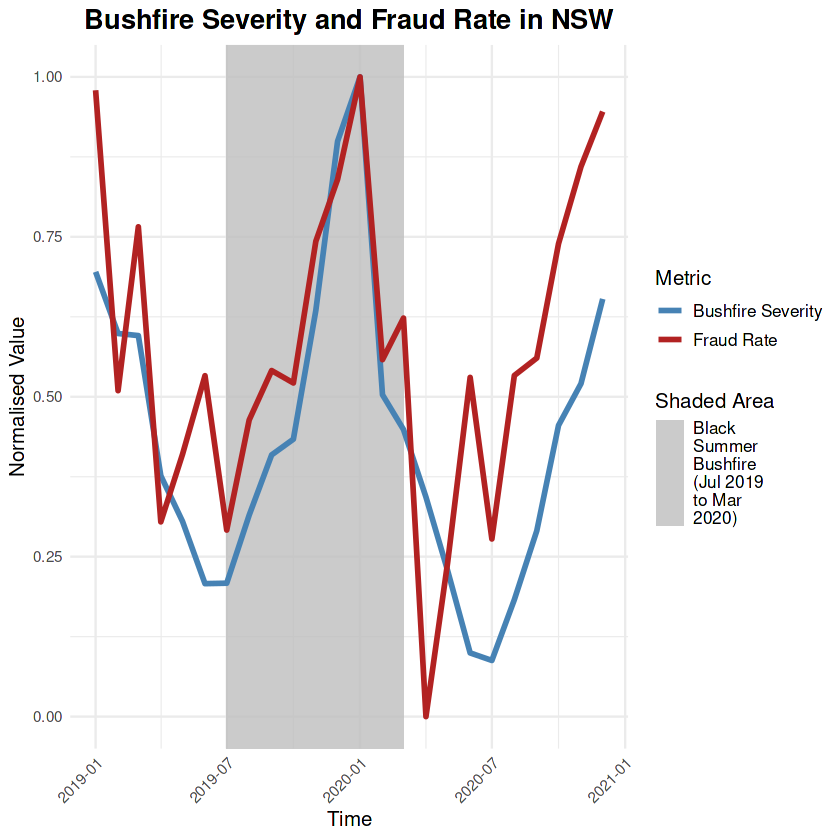

In [24]:
# Load libraries
library(dplyr)
library(ggplot2)
library(scales)
library(stringr)

# Combine year and month into a date variable
clean_fire_data <- clean_fire_data %>%
  mutate(time = as.Date(paste0(year, "-", month, "-01")))

# Average brightness per time
avg_brightness_data <- clean_fire_data %>%
  group_by(time) %>%
  summarize(avg_brightness = mean(brightness, na.rm = TRUE), .groups = "drop")

# Average fraud_rate per time (remove NAs)
avg_fraud_data <- clean_fire_data %>%
  filter(!is.na(fraud_rate)) %>%
  group_by(time) %>%
  summarize(avg_fraud_rate = mean(fraud_rate), .groups = "drop")

# Merge into one dataframe
combined_data <- left_join(avg_brightness_data, avg_fraud_data, by = "time")

# Normalize both for plotting on the same scale (0–1)
normalised_data <- combined_data %>%
  mutate(
    brightness_norm = (avg_brightness - min(avg_brightness)) / (max(avg_brightness) - min(avg_brightness)),
    fraud_rate_norm = (avg_fraud_rate - min(avg_fraud_rate, na.rm = TRUE)) /
                      (max(avg_fraud_rate, na.rm = TRUE) - min(avg_fraud_rate, na.rm = TRUE))
  )

# Convert to long format for ggplot
plot_data_season <- normalised_data %>%
  # Keep only the rows where the year is less than 2021
  filter(lubridate::year(time) < 2021) %>%
  select(time, brightness_norm, fraud_rate_norm) %>%
  tidyr::pivot_longer(cols = c(brightness_norm, fraud_rate_norm),
                      names_to = "variable", values_to = "value")

# Define the shading period
shading_start <- as.Date("2019-07-01")
shading_end <- as.Date("2020-03-01")

# Create a one-row data frame for shading
shading_label <- str_wrap(paste0("Black Summer Bushfire (Jul 2019 to Mar 2020)"), width = 10)
shading_df <- data.frame(
  xmin = shading_start,
  xmax = shading_end,
  ymin = -Inf,
  ymax = Inf,
  period = shading_label
)

ggplot(plot_data_season, aes(x = time, y = value, color = variable)) +
  # Add shaded region from separate data
  geom_rect(data = shading_df,
            aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, fill = period),
            alpha = 0.8, inherit.aes = FALSE) +
  geom_line(size = 1.2) +
  scale_color_manual(values = c("brightness_norm" = "steelblue", "fraud_rate_norm" = "firebrick"),
                     labels = c("Bushfire Severity", "Fraud Rate")) +
  scale_fill_manual(values = setNames("grey", shading_label), name = "Shaded Area") +  # Corrected line
  labs(title = "Bushfire Severity and Fraud Rate in NSW",
       x = "Time",
       y = "Normalised Value",
       color = "Metric") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.box = "vertical"
  )

In [25]:
head(plot_data_season)

time,variable,value
<date>,<chr>,<dbl>
2019-01-01,brightness_norm,0.6953188
2019-01-01,fraud_rate_norm,0.9791686
2019-02-01,brightness_norm,0.5988899
2019-02-01,fraud_rate_norm,0.5095322
2019-03-01,brightness_norm,0.5956062
2019-03-01,fraud_rate_norm,0.7656700


## Most affected suburbs vs least affected suburbs 

Top 50 Most Affected Suburbs (by brightness during shading period):


# A tibble: 50 × 2
   suburb       avg_brightness
   <chr>                 <dbl>
 1 Ku-Ring-Gai            344.
 2 Randwick               342.
 3 Griffith               341.
 4 Albury                 338.
 5 Parramatta             338.
 6 Edward River           336.
 7 Balranald              336.
 8 Ryde                   336.
 9 Cabonne                336.
10 Murrumbidgee           336.
# ℹ 40 more rows



Top 50 Least Affected Suburbs (by brightness during shading period):


# A tibble: 50 × 2
   suburb                  avg_brightness
   <chr>                            <dbl>
 1 Warren                            323.
 2 Gwydir                            323.
 3 Shoalhaven                        323.
 4 Mid-Coast                         323.
 5 Narromine                         322.
 6 Temora                            322.
 7 Hilltops                          322.
 8 Orange                            322.
 9 Port Macquarie-Hastings           322.
10 Gunnedah                          322.
# ℹ 40 more rows


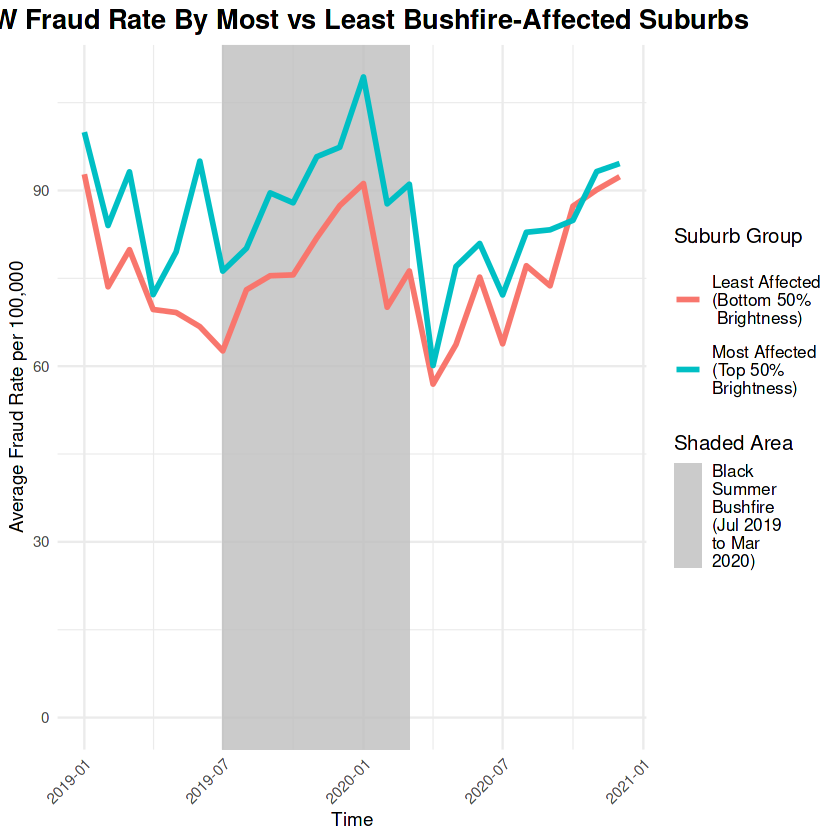

In [26]:
# Convert time to Date format if not already
clean_fire_data$time <- as.Date(clean_fire_data$time)

# Filter data within shading start and end period
shading_start <- as.Date("2019-07-01")
shading_end <- as.Date("2020-03-01")

filtered_data <- clean_fire_data %>%
  filter(time >= shading_start & time <= shading_end)

# Compute average brightness per suburb within the shading period
suburb_brightness <- filtered_data %>%
  group_by(suburb) %>%
  summarise(avg_brightness = mean(brightness, na.rm = TRUE)) %>%
  arrange(desc(avg_brightness))

# Get top 50 most and least affected suburbs
top50_suburbs <- head(suburb_brightness, 50)
bottom50_suburbs <- tail(suburb_brightness, 50)

# Print suburbs and brightness values
cat("Top 50 Most Affected Suburbs (by brightness during shading period):\n")
print(top50_suburbs)

cat("\nTop 50 Least Affected Suburbs (by brightness during shading period):\n")
print(bottom50_suburbs)

# Add group label to each
top50_suburbs$group <- "Most Affected\n(Top 50%\nBrightness)"
bottom50_suburbs$group <- "\nLeast Affected\n(Bottom 50%\n Brightness)\n"

# Combine and filter original data
target_suburbs <- bind_rows(top50_suburbs, bottom50_suburbs)

# Join group info back into original data, keeping all time values
plot_data_compare <- clean_fire_data %>%
  # Add the filter here to remove data from 2021 onwards
  filter(lubridate::year(time) < 2021) %>%
  semi_join(target_suburbs, by = "suburb") %>%
  left_join(select(target_suburbs, suburb, group), by = "suburb") %>%
  group_by(time, group) %>%
  summarise(avg_fraud_rate = mean(fraud_rate, na.rm = TRUE), .groups = 'drop')

# Create a one-row data frame for shading
shading_label <- stringr::str_wrap("Black Summer Bushfire (Jul 2019 to Mar 2020)", width = 10)
shading_df <- data.frame(
  xmin = shading_start,
  xmax = shading_end,
  ymin = -Inf,
  ymax = Inf,
  period = shading_label
)

# Plot the line chart with shaded region
ggplot(plot_data_compare, aes(x = time, y = avg_fraud_rate, color = group)) +
  # Add shaded region
  geom_rect(data = shading_df,
            aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, fill = period),
            alpha = 0.8, inherit.aes = FALSE) +
  geom_line(size = 1.2) +
  scale_fill_manual(values = setNames("grey", shading_label), name = "Shaded Area") +
  ylim(0, NA) +  # Start y-axis at 0
  labs(title = "NSW Fraud Rate By Most vs Least Bushfire-Affected Suburbs",
       x = "Time",
       y = "Average Fraud Rate per 100,000",
       color = "Suburb Group") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )

In [27]:
head(plot_data_compare)

time,group,avg_fraud_rate
<date>,<chr>,<dbl>
2019-01-01,Least Affected (Bottom 50% Brightness),92.77500
2019-01-01,Most Affected (Top 50% Brightness),99.96818
2019-02-01,Least Affected (Bottom 50% Brightness),73.55833
2019-02-01,Most Affected (Top 50% Brightness),84.02500
2019-03-01,Least Affected (Bottom 50% Brightness),79.88750
2019-03-01,Most Affected (Top 50% Brightness),93.18182


---

Let's move onto plotting the maps now

In [28]:
# Load shapefile
shapefile <- st_read("clean_fire_fraud_location.shp")


# Filter by date range, non-null brightness, and valid geometry
shapefile_filtered_data <- shapefile %>%
  filter(year_month >= "2019-07" & year_month <= "2020-03")

Reading layer `clean_fire_fraud_location' from data source 
  `/kaggle/working/clean_fire_fraud_location.shp' using driver `ESRI Shapefile'
Simple feature collection with 4176 features and 8 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 140.9993 ymin: -37.50515 xmax: 159.1092 ymax: -28.24899
Geodetic CRS:  GCS_GDA2020


In [29]:
head(shapefile_filtered_data)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,suburb,year_month,brightness,fraud_rate,year,month,AREASQKM,bad_flag,geometry
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<MULTIPOLYGON [°]>
1,Albury,2019-07,NA,106.7,2019,07,305.6386,0,MULTIPOLYGON (((146.8663 -3...
2,Albury,2019-08,NA,110.4,2019,08,305.6386,0,MULTIPOLYGON (((146.8663 -3...
3,Albury,2019-09,337.5700,97.5,2019,09,305.6386,0,MULTIPOLYGON (((146.8663 -3...
4,Albury,2019-10,321.1767,93.8,2019,10,305.6386,0,MULTIPOLYGON (((146.8663 -3...
5,Albury,2019-11,NA,104.9,2019,11,305.6386,0,MULTIPOLYGON (((146.8663 -3...
6,Albury,2019-12,344.8915,150.9,2019,12,305.6386,0,MULTIPOLYGON (((146.8663 -3...


## Bushfire Severity Map

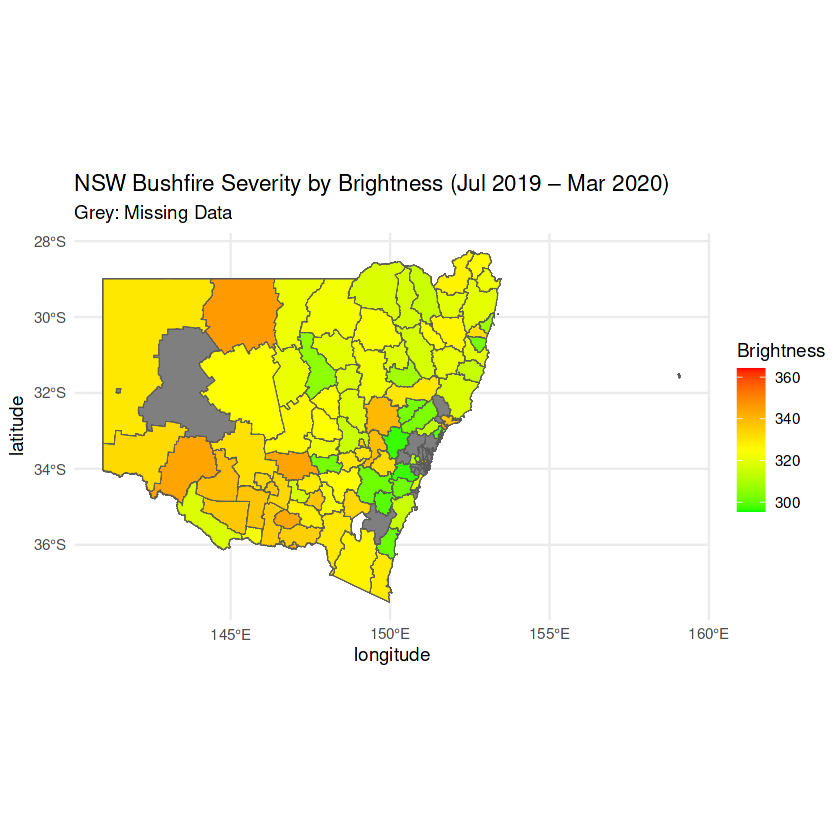

In [30]:
ggplot(data = shapefile_filtered_data) +
  geom_sf(fill = NA, color = "black", size = 0.1) +  # Draw borders
  geom_sf(aes(fill = brightness)) +                  # Fill by brightness
  # facet_wrap(~year_month) +                        # Facet by year_month (uncomment if needed)
  scale_fill_gradientn(
    colors = c("green", "yellow", "red"),  # Low → Mid → High
    values = scales::rescale(c(
      min(shapefile_filtered_data$brightness, na.rm = TRUE),
      median(shapefile_filtered_data$brightness, na.rm = TRUE),
      max(shapefile_filtered_data$brightness, na.rm = TRUE)
    ))
  ) +
  labs(title = "NSW Bushfire Severity by Brightness (Jul 2019 – Mar 2020)",
       subtitle = "Grey: Missing Data",
       fill = "Brightness",
       x = 'longitude',
       y = 'latitude') +
  theme_minimal()

This map of NSW shows that the west region was impacted by bushfires the most. 

In [31]:
simplified_map_all_aggregated <- shapefile_filtered_data %>%
  group_by(suburb) %>%
  summarise(
    fraud_rate = mean(fraud_rate, na.rm = TRUE),
    brightness = mean(brightness, na.rm = TRUE)
  ) %>%
  # After aggregation, transform the CRS to WGS84 (EPSG:4326) for web mapping
  st_transform(crs = 4326) %>%
  # Simplify the geometries to reduce file size and improve rendering speed
  st_simplify(preserveTopology = TRUE, dTolerance = 0.01)

# At this point, 'simplified_map_all_aggregated' is an sf data frame
# with unique rows for each suburb and their averaged values

# Inspect the first few rows of the result to verify
print(head(simplified_map_all_aggregated))


Simple feature collection with 6 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 142.4523 ymin: -37.50515 xmax: 152.4281 ymax: -29.93994
Geodetic CRS:  WGS 84
# A tibble: 6 × 4
  suburb            fraud_rate brightness                               geometry
  <chr>                  <dbl>      <dbl>                     <MULTIPOLYGON [°]>
1 Albury                 114.        338. (((146.8673 -36.0733, 146.8697 -36.07…
2 Armidale Regional      102.        326. (((152.3877 -30.5222, 152.3874 -30.52…
3 Balranald              NaN         336. (((142.9924 -33.85356, 142.9448 -33.8…
4 Bathurst Regional      101.        327. (((149.8491 -33.5277, 149.8493 -33.52…
5 Bayside                 56.7       321. (((151.1475 -33.92716, 151.1471 -33.9…
6 Bega Valley             54.6       328. (((150.0527 -37.26249, 150.0527 -37.2…


## NSW Fraud Rate Map

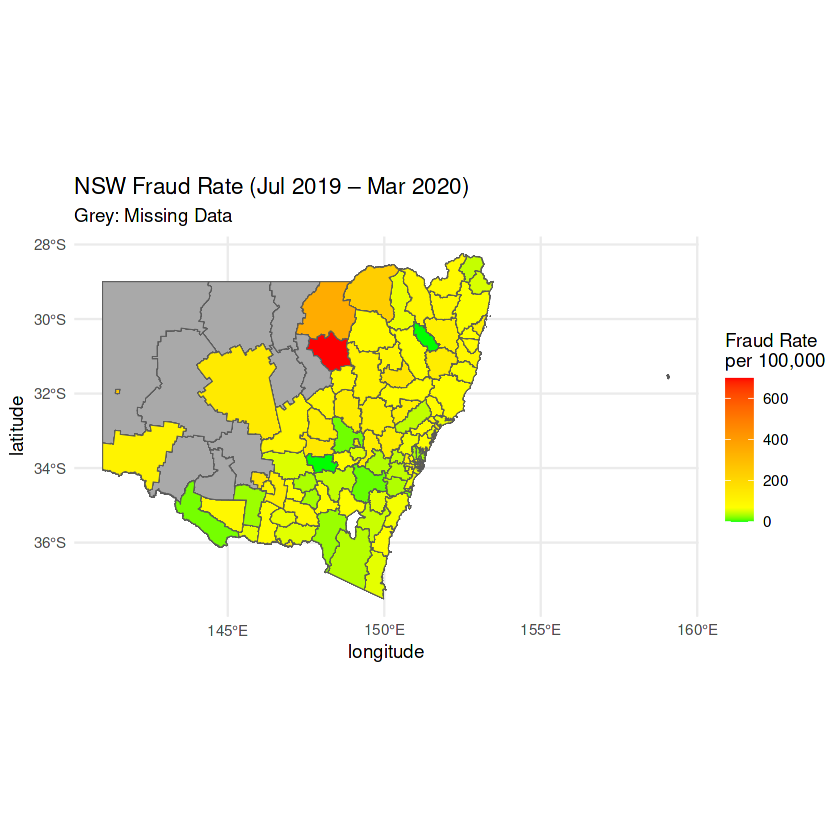

In [32]:
# shapefile_fraud_data <- shapefile_filtered_data %>%
#   filter(!is.na(fraud_rate))

ggplot(data = shapefile_filtered_data) +
  geom_sf(fill = NA, color = "black", size = 0.1) +  # Draw borders
  geom_sf(aes(fill = fraud_rate), na.rm = FALSE) +   # Ensuring NA values are 
  # facet_wrap(~year_month) +                        # Facet by year_month (uncomment if needed)
  scale_fill_gradientn(
    colors = c("green", "yellow", "red"),
    values = scales::rescale(c(
      min(shapefile_filtered_data$fraud_rate, na.rm = TRUE),
      median(shapefile_filtered_data$fraud_rate, na.rm = TRUE),
      max(shapefile_filtered_data$fraud_rate, na.rm = TRUE)
    )),
    na.value = "darkgray"  # Set missing values to light gray
  ) +
  labs(
    title = "NSW Fraud Rate (Jul 2019 – Mar 2020)", 
    fill = "Fraud Rate\nper 100,000",
    subtitle = "Grey: Missing Data",
    x = 'longitude',
    y = 'latitude'
  ) +
  theme_minimal()

Unfortunately, there are 10 states missing from the fraud map, mostly in the unincorporated west region, as crime boscar did not record fraud rates of these areas. These are the areas that were most impacted by the bushfires as shown in the bushfire severity map before. 

## Bushfire severity & Fraud Rate Correlation Map

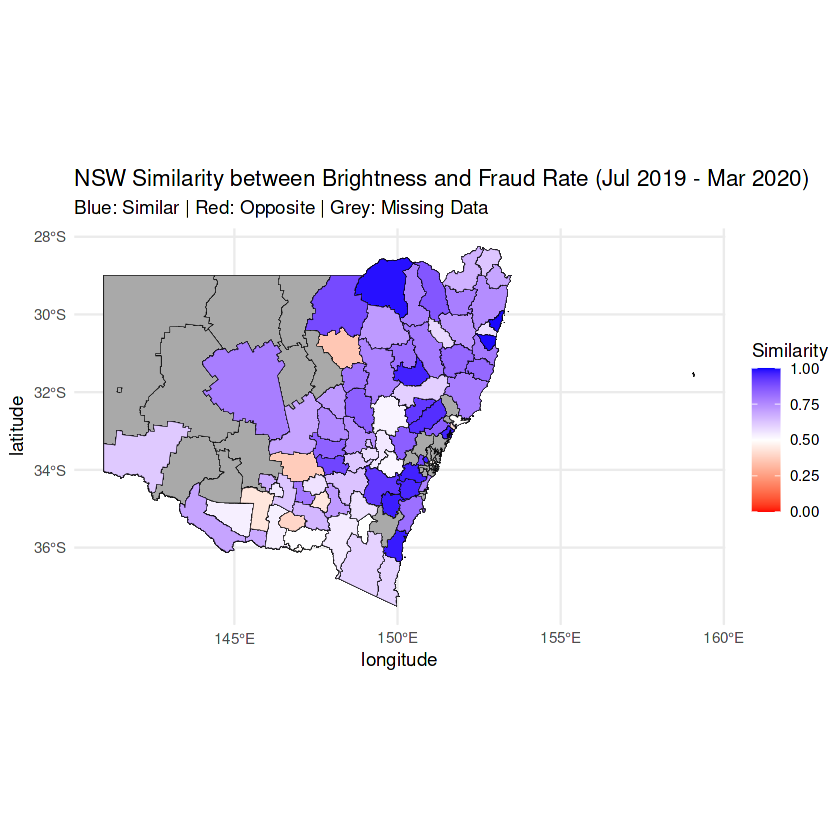

In [33]:
# Normalise and compute similarity (keeping NAs)
shapefile_similarity <- shapefile_filtered_data %>%
  mutate(
    scaled_brightness = scales::rescale(brightness, to = c(0, 1)),  # Normalize [0,1]
    scaled_fraud_rate = scales::rescale(fraud_rate, to = c(0, 1)),  # Normalize [0,1]
    similarity = 1 - abs(scaled_brightness - scaled_fraud_rate)     # 1=perfect, 0=opposite
  )


# Plot (with NA values as dark grey)
ggplot(shapefile_similarity) +
  geom_sf(
    aes(fill = similarity),  # Will automatically include NA
    color = "black", 
    size = 0.1
  ) +
  # facet_wrap(~year_month) +                        # Facet by year_month (uncomment if needed)
  scale_fill_gradientn(
    colors = c("red", "white", "blue"),  # Diverging colors
    values = scales::rescale(c(0, 0.5, 1)),  # 0=dissimilar, 1=similar
    na.value = "darkgrey",  # Assign NA regions to dark grey
    limits = c(0, 1)        # Ensure scale is fixed
  ) +
  labs(
    title = "NSW Similarity between Brightness and Fraud Rate (Jul 2019 - Mar 2020)",
    subtitle = "Blue: Similar | Red: Opposite | Grey: Missing Data",
    fill = "Similarity",
    x = 'longitude',
    y = 'latitude'
  ) +
  theme_minimal()


In [34]:
head(shapefile_similarity)

,suburb,year_month,brightness,fraud_rate,year,month,AREASQKM,bad_flag,geometry,scaled_brightness,scaled_fraud_rate,similarity
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<MULTIPOLYGON [°]>,<dbl>,<dbl>,<dbl>
1,Albury,2019-07,NA,106.7,2019,07,305.6386,0,MULTIPOLYGON (((146.8663 -3...,NA,0.1527340,NA
2,Albury,2019-08,NA,110.4,2019,08,305.6386,0,MULTIPOLYGON (((146.8663 -3...,NA,0.1580303,NA
3,Albury,2019-09,337.5700,97.5,2019,09,305.6386,0,MULTIPOLYGON (((146.8663 -3...,0.6122376,0.1395648,0.5273272
4,Albury,2019-10,321.1767,93.8,2019,10,305.6386,0,MULTIPOLYGON (((146.8663 -3...,0.3742339,0.1342685,0.7600346
5,Albury,2019-11,NA,104.9,2019,11,305.6386,0,MULTIPOLYGON (((146.8663 -3...,NA,0.1501575,NA
6,Albury,2019-12,344.8915,150.9,2019,12,305.6386,0,MULTIPOLYGON (((146.8663 -3...,0.7185341,0.2160034,0.4974694


# NSW General Fraud Analysis

In [35]:
scam_data <- read_csv("/kaggle/input/scamwatch-nsw-2020-to-2021/ScamwatNSW2020to2021.csv")

Rows: 17016 Columns: 9


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Address_State, Scam___Contact_Mode, Complainant_Age, Complainant_G...
dbl  (1): Number_of_reports
date (1): StartOfMonth



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [36]:
# Convert StartOfMonth to Date format
scam_data$StartOfMonth <- as.Date(scam_data$StartOfMonth, format = "%d/%m/%Y")

# Filter for Black Summer bushfires period (July 2019 to March 2020)
bushfire_period <- scam_data %>% 
  filter(StartOfMonth >= as.Date("01/07/2019", format = "%d/%m/%Y") & 
         StartOfMonth <= as.Date("01/03/2020", format = "%d/%m/%Y")) %>% 
  filter(Complainant_Gender %in% c("Female", "Male")) %>% 
  filter(Complainant_Age != "Unspecified" & !is.na(Complainant_Age))

# Clean Amount_lost by removing $ and converting to numeric
bushfire_period$Amount_lost <- as.numeric(gsub("[$,]", "", bushfire_period$Amount_lost))

# Define the correct age group order
age_order <- c("Under 18", "18 - 24", "25 - 34", "35 - 44", "45 - 54", "55 - 64", "65 and over")

# Apply the factor levels to the Age column
bushfire_period$Complainant_Age <- factor(bushfire_period$Complainant_Age, levels = age_order)

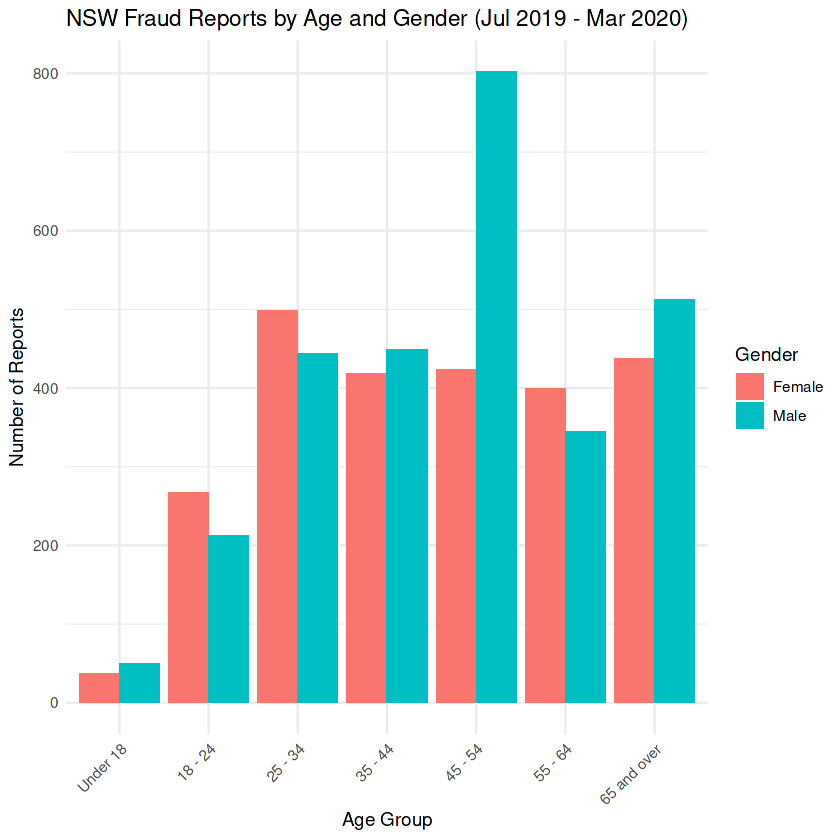

In [37]:
age_gender_analysis <- bushfire_period %>%
  group_by(Complainant_Age, Complainant_Gender) %>%
  summarise(
    Total_Reports = sum(Number_of_reports, na.rm = TRUE),
    .groups = 'drop') %>%
  filter(!is.na(Complainant_Gender) & !is.na(Complainant_Age))
  
# Visualise
ggplot(age_gender_analysis, aes(x = Complainant_Age, y = Total_Reports, fill = Complainant_Gender)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "NSW Fraud Reports by Age and Gender (Jul 2019 - Mar 2020)",
       x = "Age Group", y = "Number of Reports", fill = "Gender") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = c("Female" = "#F8766D", "Male" = "#00BFC4")) # Added distinct color

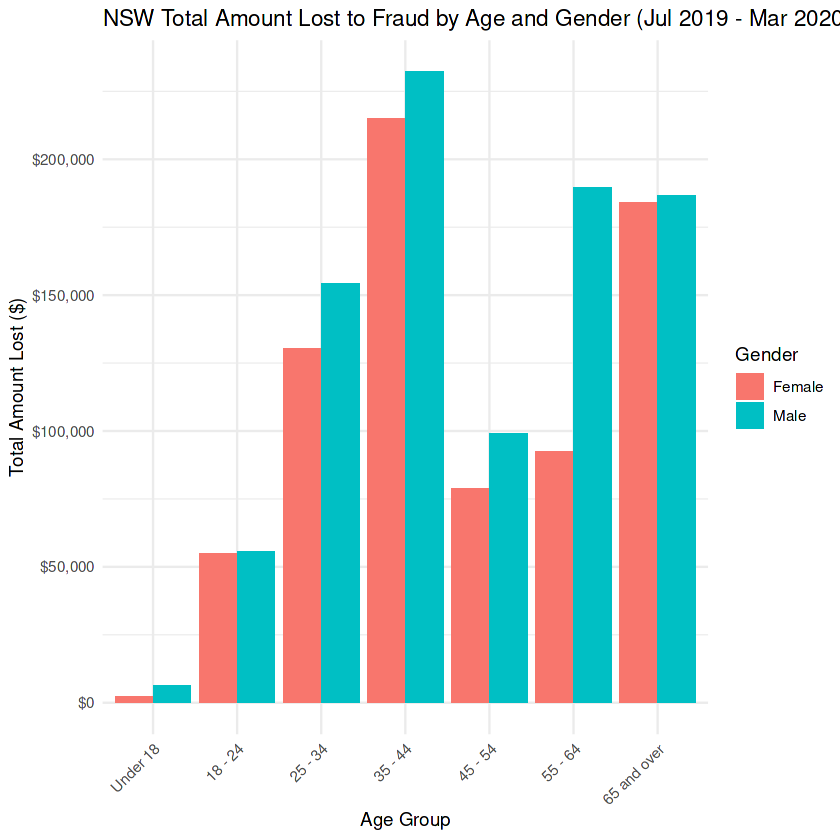

In [38]:
# Analysis of Amount Lost by Age and Gender
amount_lost_analysis <- bushfire_period %>%
  group_by(Complainant_Age, Complainant_Gender) %>%
  summarise(
    Total_Amount_Lost = sum(Amount_lost, na.rm = TRUE),
    Average_Amount_Lost = mean(Amount_lost, na.rm = TRUE),
    Median_Amount_Lost = median(Amount_lost, na.rm = TRUE),
    Number_of_Reports = sum(Number_of_reports, na.rm = TRUE),
    .groups = 'drop') %>%
  filter(!is.na(Complainant_Gender) & !is.na(Complainant_Age))

# Visualize Total Amount Lost
ggplot(amount_lost_analysis, 
       aes(x = Complainant_Age, y = Total_Amount_Lost, fill = Complainant_Gender)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "NSW Total Amount Lost to Fraud by Age and Gender (Jul 2019 - Mar 2020)",
       x = "Age Group", y = "Total Amount Lost ($)", fill = "Gender") +
  scale_fill_manual(values = c("Female" = "#F8766D", "Male" = "#00BFC4")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_continuous(labels = scales::dollar_format())

In [39]:
head(amount_lost_analysis)

Complainant_Age,Complainant_Gender,Total_Amount_Lost,Average_Amount_Lost,Median_Amount_Lost,Number_of_Reports
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Under 18,Female,2229,202.6364,122.0,37
Under 18,Male,6372,424.8000,294.0,50
18 - 24,Female,54736,1563.8857,900.0,267
18 - 24,Male,55574,1543.7222,481.5,213
25 - 34,Female,130388,2370.6909,850.0,498
25 - 34,Male,154112,3502.5455,1017.5,444


In [40]:
# R code for combining demographic data

library(dplyr)
library(readr)

# Assuming 'bushfire_period' is your filtered dataset from the Rmd
age_gender_analysis_combined <- bushfire_period %>%
  group_by(Complainant_Age, Complainant_Gender) %>%
  summarise(
    Total_Reports = sum(Number_of_reports, na.rm = TRUE),
    Total_Amount_Lost = sum(Amount_lost, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  filter(!is.na(Complainant_Gender) & !is.na(Complainant_Age))

In [41]:
head(age_gender_analysis_combined)

Complainant_Age,Complainant_Gender,Total_Reports,Total_Amount_Lost
<fct>,<chr>,<dbl>,<dbl>
Under 18,Female,37,2229
Under 18,Male,50,6372
18 - 24,Female,267,54736
18 - 24,Male,213,55574
25 - 34,Female,498,130388
25 - 34,Male,444,154112


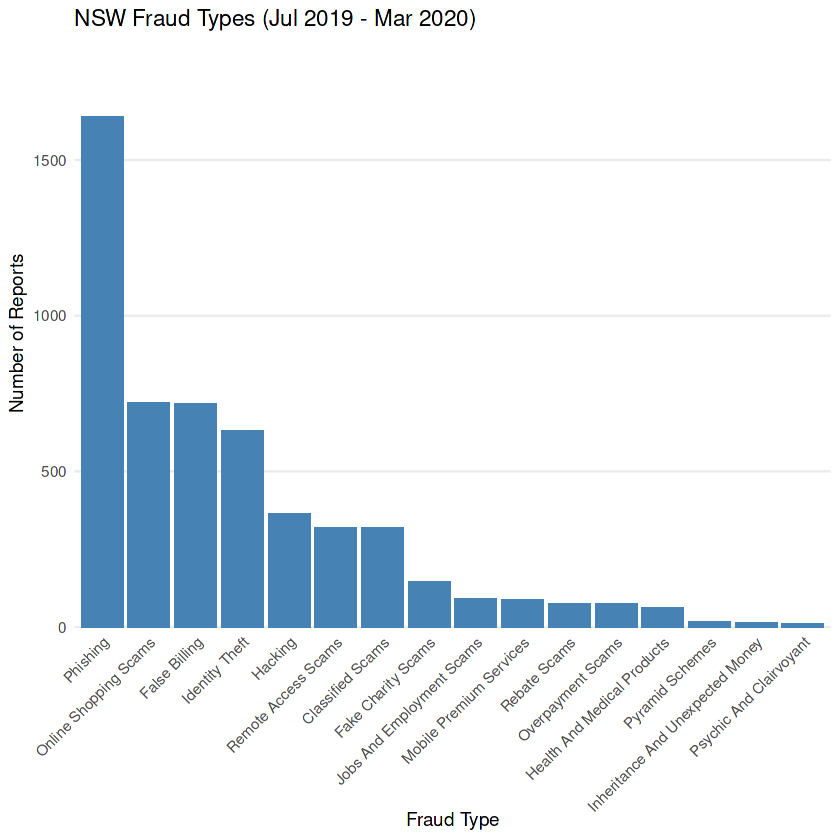

In [42]:
# Assume 'bushfire_period' dataframe is already loaded

# Combine categories and analyze fraud type distribution
fraud_type_analysis <- bushfire_period %>%
  unite("Fraud_Type", Category_Level_2, Category_Level_3, sep = " - ") %>%
  mutate(
    Fraud_Type = str_replace(Fraud_Type, "^Attempts to gain your personal information - ", ""),
    Fraud_Type = str_replace(Fraud_Type, "^Buying or selling - ", ""),
    Fraud_Type = str_replace(Fraud_Type, "^Fake charities - ", ""),
    Fraud_Type = str_replace(Fraud_Type, "^Jobs and employment - ", ""),
    Fraud_Type = str_replace(Fraud_Type, "^Unexpected money - ", ""),
    Fraud_Type = str_replace(Fraud_Type, " - .*$", ""),  # Remove any remaining suffixes after hyphen
    Fraud_Type = str_to_title(Fraud_Type)  # Capitalize first letters
  ) %>%
  group_by(Fraud_Type) %>%
  summarise(
    Total_Reports = sum(Number_of_reports, na.rm = TRUE),
    Total_Amount_Lost = sum(Amount_lost, na.rm = TRUE),
    .groups = 'drop')

# Data for plotting all fraud types by number of reports
all_fraud_by_reports <- fraud_type_analysis %>%
  mutate(Fraud_Type = fct_reorder(Fraud_Type, -Total_Reports)) # Order from highest to lowest

# Bar chart for all fraud types by number of reports
ggplot(all_fraud_by_reports, aes(x = Fraud_Type, y = Total_Reports)) +
  geom_col(fill = "steelblue") +
  scale_y_continuous(expand = expansion(mult = c(0, 0.15))) + # Increased expansion for labels
  labs(title = "NSW Fraud Types (Jul 2019 - Mar 2020)",
       x = "Fraud Type",
       y = "Number of Reports") +
  theme_minimal() +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis labels

In [43]:
head(all_fraud_by_reports)

Fraud_Type,Total_Reports,Total_Amount_Lost
<fct>,<dbl>,<dbl>
Classified Scams,320,217573
Fake Charity Scams,146,1765
False Billing,718,301547
Hacking,365,73585
Health And Medical Products,63,14911
Identity Theft,631,187294


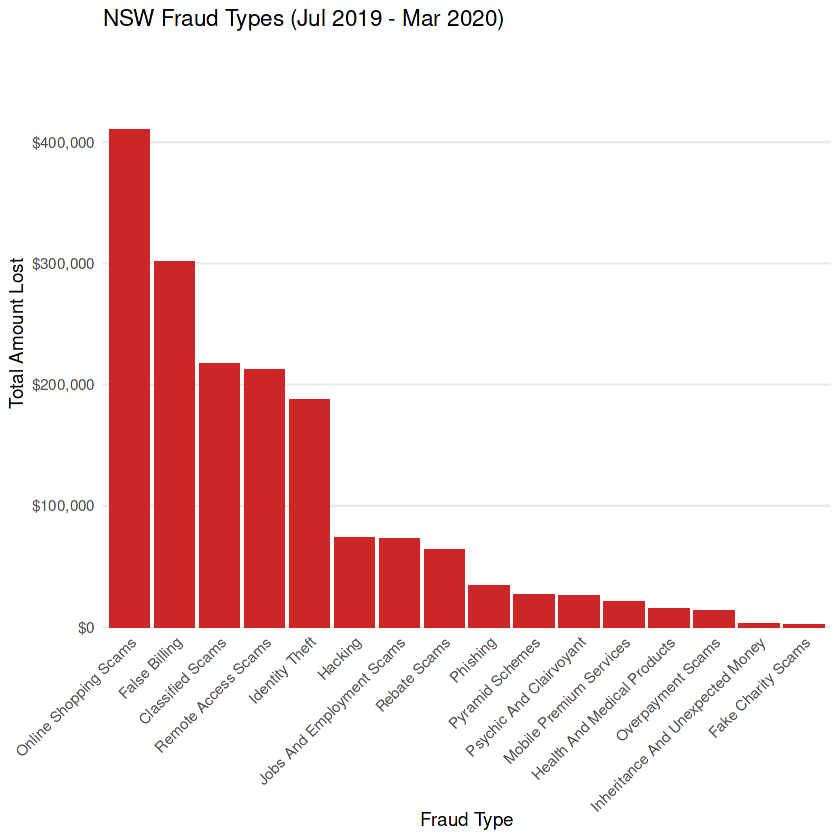

In [44]:
# Data for plotting all fraud types by amount lost
all_fraud_by_loss <- fraud_type_analysis %>%
  filter(Total_Amount_Lost > 0) %>% # Optional: remove types with zero loss
  mutate(Fraud_Type = fct_reorder(Fraud_Type, -Total_Amount_Lost)) # Order from highest to lowest

# Bar chart for all fraud types by total amount lost
ggplot(all_fraud_by_loss, aes(x = Fraud_Type, y = Total_Amount_Lost)) +
  geom_col(fill = "firebrick3") +
  # Removed scale_cut from the axis formatting to ensure consistency and prevent errors.
  scale_y_continuous(expand = expansion(mult = c(0, 0.18)), 
                     labels = dollar_format()) + # Format y-axis
  labs(title = "NSW Fraud Types (Jul 2019 - Mar 2020)",
       x = "Fraud Type",
       y = "Total Amount Lost") +
  theme_minimal() +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis labels

In [45]:
head(all_fraud_by_loss)

Fraud_Type,Total_Reports,Total_Amount_Lost
<fct>,<dbl>,<dbl>
Classified Scams,320,217573
Fake Charity Scams,146,1765
False Billing,718,301547
Hacking,365,73585
Health And Medical Products,63,14911
Identity Theft,631,187294
